In [10]:
import math
import numpy as np
from numba import cuda
from numba import njit
from scipy.linalg import lstsq

# ============================================================
# GPU code from user snippet
tol = 1e-15
max_terms = 4096

@cuda.jit(device=True)
def _2F1_device(a, b, c, z_r, z_i):
    if c == 0.0:
        return 1.0, 0.0
    real_accum = 1.0
    imag_accum = 0.0
    term_r = 1.0
    term_i = 0.0
    for n in range(1, max_terms):
        denom = n*(c+n-1.0)
        poch = ((a+n-1.0)*(b+n-1.0))/denom
        zr = term_r*z_r - term_i*z_i
        zi = term_r*z_i + term_i*z_r
        term_r = poch*zr
        term_i = poch*zi
        if (abs(term_r)<tol) and (abs(term_i)<tol):
            break
        real_accum += term_r
        imag_accum += term_i
    return real_accum, imag_accum

@cuda.jit(device=True)
def compute_g_device(d_val, s_val, x, y):
    # h = (Delta + s)/2, hb = (Delta - s)/2
    h = 0.5*(d_val + s_val)
    hb = 0.5*(d_val - s_val)

    # Compute hypergeometric parts:
    z_r, z_i = x, y
    xp = 1.0 - x
    yp = -y

    # We'll directly compute necessary pieces in kernel
    # See original snippet for reference
    # 2F1(h,h;2h;z)
    fhz_r, fhz_i = _2F1_device(h,h,2*h,z_r,z_i)
    # 2F1(hb,hb;2hb;z*)
    fhbz_b_r, fhbz_b_i = _2F1_device(hb,hb,2*hb,z_r,-z_i)
    # 2F1(h,h;2h;z*)
    fhz_b_r, fhz_b_i = _2F1_device(h,h,2*h,z_r,-z_i)
    # 2F1(hb,hb;2hb;z)
    fhb_z_r, fhb_z_i = _2F1_device(hb,hb,2*hb,z_r,z_i)

    # Construct g similarly as done in initial code:
    # g = (z^h z̅^{hb} * F_h(z)*F_hb(z̅) + z^{hb} z̅^{h}*F_h(z̅)*F_hb(z)) / (1 + δ_{h,hb})
    # For simplicity, we assume (1+KroneckerDelta)=1 since h,hb from continuous spectrum
    # Approximate powers:
    r = math.sqrt(x*x + y*y)
    theta = math.atan2(y,x)
    # z^h z̅^{hb}:
    # z^h = r^h * e^{i h theta}, z̅^{hb} = r^{hb} * e^{-i hb theta}
    # combined: z^h z̅^{hb} = r^{h+hb} e^{i(h - hb)theta} = r^{(h+hb)}e^{i s theta}, s=(h-hb)
    d = h+hb
    s = h-hb
    r_pow_d = r**d
    cos_s_th = math.cos(s*theta)
    sin_s_th = math.sin(s*theta)
    # z^h z̅^{hb} = r^d(cos(sθ) + i sin(sθ))
    # Similarly, z^{hb} z̅^h = r^d(cos(-sθ) + i sin(-sθ)) = r^d(cos(sθ) - i sin(sθ))

    # F_h(z)*F_hb(z̅)
    step1_r = fhz_r*fhbz_b_r - fhz_i*fhbz_b_i
    step1_i = fhz_r*fhbz_b_i + fhz_i*fhbz_b_r

    # multiply by z^h z̅^{hb}:
    # (cos(sθ)+i sin(sθ))*(step1_r + i step1_i)
    tmp1_r = step1_r*cos_s_th - step1_i*sin_s_th
    tmp1_i = step1_r*sin_s_th + step1_i*cos_s_th
    T1_r = r_pow_d*tmp1_r
    T1_i = r_pow_d*tmp1_i

    # F_h(z̅)*F_hb(z)
    step2_r = fhz_b_r*fhb_z_r - fhz_b_i*fhb_z_i
    step2_i = fhz_b_r*fhb_z_i + fhz_b_i*fhb_z_r

    # z^{hb} z̅^{h} = r^d(cos(-sθ)+i sin(-sθ)) = r^d(cos(sθ)-i sin(sθ))
    # multiply step2 by (cos(sθ)- i sin(sθ))
    tmp2_r = step2_r*cos_s_th + step2_i*sin_s_th
    tmp2_i = -step2_r*sin_s_th + step2_i*cos_s_th
    T2_r = r_pow_d*tmp2_r
    T2_i = r_pow_d*tmp2_i

    g_r = T1_r + T2_r
    g_i = T1_i + T2_i
    return g_r, g_i

@cuda.jit
def compute_g_delta_kernel(d_arr, s_arr, x_arr, y_arr, dphi, g_delta_matrix):
    j, i = cuda.grid(2)
    N = x_arr.size
    M = d_arr.size
    if j < N and i < M:
        d_val = d_arr[i]
        s_val = s_arr[i]

        x = x_arr[j]
        y = y_arr[j]
        # g(h,hb,z)
        g1_r, g1_i = compute_g_device(d_val, s_val, x, y)

        xp = 1.0 - x
        yp = -y
        # g(h,hb,1-z)
        g2_r, g2_i = compute_g_device(d_val, s_val, xp, yp)

        # Compute factors |z-1|^{2 dSigma} and |z|^{2 dSigma}
        zm1_r = x - 1.0
        zm1_i = y
        # |z-1|^2 = (zm1_r^2+zm1_i^2)
        r1 = math.sqrt(zm1_r*zm1_r + zm1_i*zm1_i)
        # |z| = sqrt(x^2+y^2)
        r2 = math.sqrt(x*x + y*y)

        # (|z-1|^(2 dSigma)*g1 - |z|^(2 dSigma)*g2)
        r1_pow = r1**(2*dphi)
        r2_pow = r2**(2*dphi)
        val_r = r1_pow*g1_r - r2_pow*g2_r
        # Imag parts negligible for final eq (expected real), ignoring imaginary since original eq focuses on real
        idx = j*M + i
        g_delta_matrix[idx] = val_r

def calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dphi):
    N = len(x_values)
    M = len(d_values)
    g_delta_device = cuda.device_array(N*M, dtype=np.float64)

    d_device = cuda.to_device(np.array(d_values,dtype=np.float64))
    s_device = cuda.to_device(np.array(s_values,dtype=np.float64))
    x_device = cuda.to_device(x_values.astype(np.float64))
    y_device = cuda.to_device(y_values.astype(np.float64))

    threads_per_block = (16,16)
    blocks_x = (M+threads_per_block[0]-1)//threads_per_block[0]
    blocks_y = (N+threads_per_block[1]-1)//threads_per_block[1]

    compute_g_delta_kernel[(blocks_y,blocks_x), threads_per_block](
        d_device, s_device, x_device, y_device, dphi, g_delta_device
    )

    return g_delta_device.copy_to_host().reshape(N,M)

# ============================================================
# CPU helpers
@njit
def abs_z_power(zr, zi, alpha):
    # Compute |z|^alpha
    r = math.sqrt(zr*zr+zi*zi)
    return r**alpha

def leastSqRew(deltas, spins, dSigma):
    # 1) Generate random z-points
    N_z = 100
    zs = np.zeros(N_z, dtype=np.complex128)
    np.random.seed(0)
    for i in range(N_z):
        r = np.random.normal(0,0.1)
        phi = math.pi - (math.pi/2)*np.random.rand()
        zpt = 0.5 + r*(math.cos(phi)+1j*math.sin(phi))
        zs[i] = zpt

    x_values = zs.real
    y_values = zs.imag

    # 2) Construct G matrix using GPU
    # d_values = deltas, s_values = spins
    # According to definition: h=(Δ+s)/2, hb=(Δ-s)/2
    # The kernel expects d_val=Δ, s_val=s
    d_values = deltas
    s_values = spins
    G = calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dSigma)

    # 3) Compute v (with C[i]=0):
    # v(z) = |z-1|^(2 dSigma)-|z|^(2 dSigma)
    v = np.zeros(N_z, dtype=np.float64)
    for i in range(N_z):
        x = x_values[i]
        y = y_values[i]
        zm1x = x-1.0
        zm1y = y
        abs_zm1 = math.sqrt(zm1x*zm1x+zm1y*zm1y)
        abs_z = math.sqrt(x*x+y*y)
        v[i] = abs_zm1**(2*dSigma)-abs_z**(2*dSigma)

    # 4) Solve least squares: we want c minimizing |G c + v|^2
    # Actually we solve G c = -v
    # => c = argmin_c ||G c + v||^2
    # Shift: Let v' = -v, solve G c = -v
    rhs = -v
    # We can use lstsq to solve min||G c - rhs||^2
    c, residuals, rank, s = lstsq(G, rhs)

    # 5) Compute residual
    res = G @ c + v
    # Following the original definition: r = -Log(res^T res) with some weighting?
    # The original code used a weighting Winv derived from G's last column. 
    # If we want to mimic original:
    # Winv = diag(G[:, -1]) from original code is unclear. Let's just compute a plain residual norm:
    norm_res = res @ res
    r = -math.log(norm_res) if norm_res > 1e-14 else -math.log(1e-14)

    return c, r

# Example usage:
if __name__ == "__main__":
    deltas = np.array([1.2, 1.5, 2.0, 2.5])
    spins = np.array([0.0, 2.0, 4.0, 0.0])  
    dSigma = 0.5
    c, r = leastSqRew(deltas, spins, dSigma)
    print("c:", c)
    print("r:", r)


/home/string-1/anaconda3/envs/ML/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


c: [ 0.81023002 -0.48193918  0.09784027  0.30964126]
r: 12.253608431228596


In [4]:
%timeit leastSqRew(deltas, spins, dSigma)

2.12 ms ± 81.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


d2=1.100, d3=2.800, r=11.451
d2=1.100, d3=2.891, r=11.404
d2=1.100, d3=2.982, r=11.567
d2=1.100, d3=3.073, r=10.667
d2=1.100, d3=3.164, r=10.863
d2=1.100, d3=3.255, r=10.841
d2=1.100, d3=3.345, r=10.791
d2=1.100, d3=3.436, r=10.735
d2=1.100, d3=3.527, r=10.679
d2=1.100, d3=3.618, r=10.623
d2=1.100, d3=3.709, r=10.569
d2=1.100, d3=3.800, r=10.517
d2=1.100, d3=3.891, r=10.466
d2=1.100, d3=3.982, r=10.418
d2=1.100, d3=4.073, r=10.372
d2=1.100, d3=4.164, r=10.328
d2=1.100, d3=4.255, r=10.285
d2=1.100, d3=4.345, r=10.244
d2=1.100, d3=4.436, r=10.204
d2=1.100, d3=4.527, r=10.166
d2=1.100, d3=4.618, r=10.130
d2=1.100, d3=4.709, r=10.094
d2=1.100, d3=4.800, r=10.060
d2=1.100, d3=4.891, r=10.027
d2=1.100, d3=4.982, r=9.995
d2=1.100, d3=5.073, r=9.964
d2=1.100, d3=5.164, r=9.933
d2=1.100, d3=5.255, r=9.904
d2=1.100, d3=5.345, r=9.876
d2=1.100, d3=5.436, r=9.848
d2=1.100, d3=5.527, r=9.822
d2=1.100, d3=5.618, r=9.796
d2=1.100, d3=5.709, r=9.770
d2=1.100, d3=5.800, r=9.746
d2=1.189, d3=2.800, r=11

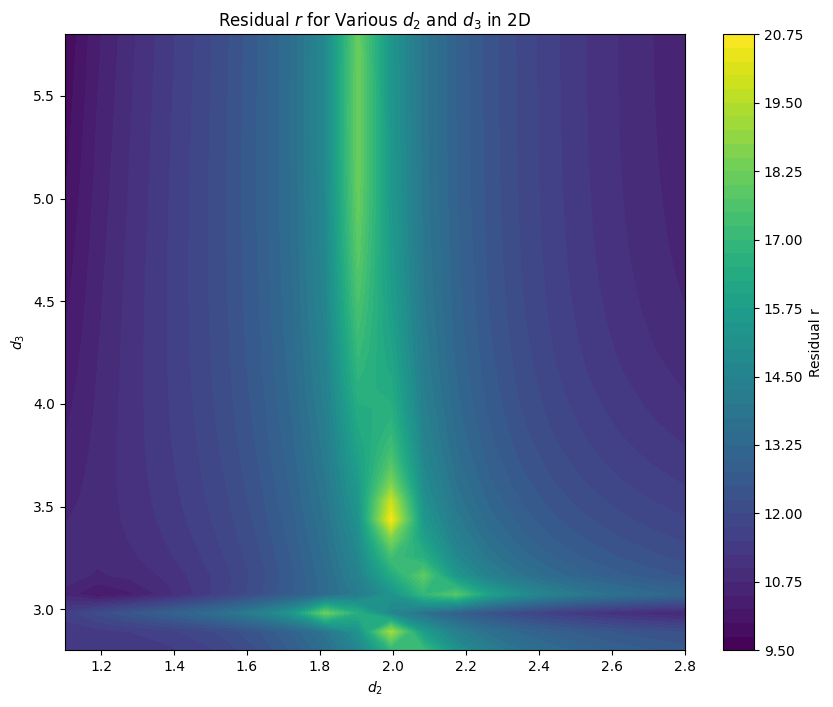

In [6]:
import matplotlib.pyplot as plt
def plot_r(d2_vals, d3_vals, r_matrix):
    plt.figure(figsize=(10, 8))
    # Create meshgrid
    D2, D3 = np.meshgrid(d2_vals, d3_vals, indexing='ij')
    # Plot r as contour
    cp = plt.contourf(D2, D3, r_matrix, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Residual r')
    plt.xlabel('$d_2$')
    plt.ylabel('$d_3$')
    plt.title('Residual $r$ for Various $d_2$ and $d_3$ in 2D')
    plt.show()

# ============================================================
# Example usage:
if __name__ == "__main__":
    # Define spinsYL, assuming [0.0, 2.0, 4.0, 0.0]
    spinsYL = [0.0, 2.0, 4.0, 0.0]

    # Define d2 and d3 ranges
    step = 1.0 / 11.0
    d2_start = 11.0 / 10.0  # 1.1
    d2_end = 28.0 / 10.0    # 2.8
    d3_start = 28.0 / 10.0  # 2.8
    d3_end = 58.0 / 10.0    # 5.8

    # Generate step sizes
    num_steps_d2 = int(round((d2_end - d2_start) / step)) + 1
    num_steps_d3 = int(round((d3_end - d3_start) / step)) + 1

    d2_vals = np.linspace(d2_start, d2_end, num_steps_d2)
    d3_vals = np.linspace(d3_start, d3_end, num_steps_d3)

    # Prepare a grid to store r
    r_matrix = np.zeros((len(d2_vals), len(d3_vals)), dtype=np.float64)

    # Iterate over d2 and d3
    for i, d2 in enumerate(d2_vals):
        for j, d3 in enumerate(d3_vals):
            deltas = np.array([ -2.0/5.0, d2, d3, 38.0/5.0 ])
            try:
                c, r = leastSqRew(deltas, spinsYL, dSigma=-4.0/10.0)
                r_matrix[i,j] = r
            except Exception as e:
                # Handle exceptions (e.g., singular matrix)
                print(f"Error at d2={d2:.3f}, d3={d3:.3f}: {e}")
                r_matrix[i,j] = np.nan
            print(f"d2={d2:.3f}, d3={d3:.3f}, r={r:.3f}")

    # Plot the residuals
    plot_r(d2_vals, d3_vals, r_matrix)

/home/string-1/anaconda3/envs/ML/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


d2=1.100, d3=2.800, r=-4.304
d2=1.100, d3=2.891, r=-4.304
d2=1.100, d3=2.982, r=-4.304
d2=1.100, d3=3.073, r=-4.304
d2=1.100, d3=3.164, r=-4.304
d2=1.100, d3=3.255, r=-4.304
d2=1.100, d3=3.345, r=-4.304
d2=1.100, d3=3.436, r=-4.304
d2=1.100, d3=3.527, r=-4.304
d2=1.100, d3=3.618, r=-4.304
d2=1.100, d3=3.709, r=-4.304
d2=1.100, d3=3.800, r=-4.304
d2=1.100, d3=3.891, r=-4.304
d2=1.100, d3=3.982, r=-4.304
d2=1.100, d3=4.073, r=-4.304
d2=1.100, d3=4.164, r=-4.304
d2=1.100, d3=4.255, r=-4.304
d2=1.100, d3=4.345, r=-4.304
d2=1.100, d3=4.436, r=-4.304
d2=1.100, d3=4.527, r=-4.304
d2=1.100, d3=4.618, r=-4.304
d2=1.100, d3=4.709, r=-4.304
d2=1.100, d3=4.800, r=-4.304
d2=1.100, d3=4.891, r=-4.304
d2=1.100, d3=4.982, r=-4.304
d2=1.100, d3=5.073, r=-4.304
d2=1.100, d3=5.164, r=-4.304
d2=1.100, d3=5.255, r=-4.304
d2=1.100, d3=5.345, r=-4.304
d2=1.100, d3=5.436, r=-4.304
d2=1.100, d3=5.527, r=-4.304
d2=1.100, d3=5.618, r=-4.304
d2=1.100, d3=5.709, r=-4.304
d2=1.100, d3=5.800, r=-4.304
d2=1.189, d3=2

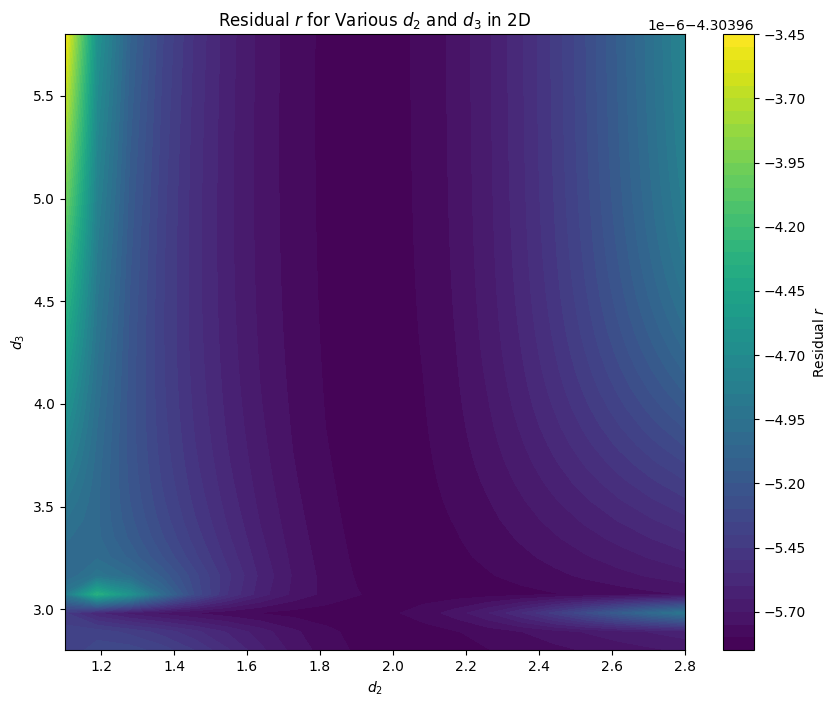

In [31]:
import math
import numpy as np
from numba import cuda, njit
from scipy.linalg import lstsq
import matplotlib.pyplot as plt

# ============================================================
# GPU code for hypergeometric function and compute_g
tol = 1e-15
max_terms = 4096

@cuda.jit(device=True)
def _2F1_device(a, b, c, z_r, z_i):
    if c == 0.0:
        return 1.0, 0.0
    real_accum = 1.0
    imag_accum = 0.0
    term_r = 1.0
    term_i = 0.0
    for n in range(1, max_terms):
        denom = n * (c + n - 1.0)
        poch = ((a + n - 1.0) * (b + n - 1.0)) / denom
        zr = term_r * z_r - term_i * z_i
        zi = term_r * z_i + term_i * z_r
        term_r = poch * zr
        term_i = poch * zi
        if (math.fabs(term_r) < tol) and (math.fabs(term_i) < tol):
            break
        real_accum += term_r
        imag_accum += term_i
    return real_accum, imag_accum

@cuda.jit(device=True)
def compute_g_device(d_val, s_val, x, y):
    # h = (Delta + s)/2, hb = (Delta - s)/2
    h = 0.5 * (d_val + s_val)
    hb = 0.5 * (d_val - s_val)

    # Compute hypergeometric parts:
    z_r, z_i = x, y
    xp = 1.0 - x
    yp = -y

    # Compute F_h(z)*F_hb(z̄)
    fhz_r, fhz_i = _2F1_device(h, h, 2 * h, z_r, z_i)
    fhbz_b_r, fhbz_b_i = _2F1_device(hb, hb, 2 * hb, z_r, -z_i)

    # Compute F_h(z̄)*F_hb(z)
    fhz_b_r, fhz_b_i = _2F1_device(h, h, 2 * h, z_r, -z_i)
    fhb_z_r, fhb_z_i = _2F1_device(hb, hb, 2 * hb, z_r, z_i)

    # Compute |z| and |z-1|
    r = math.sqrt(x * x + y * y)
    theta = math.atan2(y, x)
    s_theta = s_val * theta

    # Compute z^h z̄^hb
    d = h + hb
    s = h - hb
    r_pow_d = r ** d
    cos_s_theta = math.cos(s_theta)
    sin_s_theta = math.sin(s_theta)
    # z^h z̄^hb = r^d (cos(sθ) + i sin(sθ))
    # Similarly for z^hb z̄^h
    # Compute F_h(z) * F_hb(z̄)
    term1_r = fhz_r * fhbz_b_r - fhz_i * fhbz_b_i
    term1_i = fhz_r * fhbz_b_i + fhz_i * fhbz_b_r
    T1_r = r_pow_d * (term1_r * cos_s_theta - term1_i * sin_s_theta)
    T1_i = r_pow_d * (term1_r * sin_s_theta + term1_i * cos_s_theta)

    # Compute F_h(z̄) * F_hb(z)
    term2_r = fhz_b_r * fhb_z_r - fhz_b_i * fhb_z_i
    term2_i = fhz_b_r * fhb_z_i + fhz_b_i * fhb_z_r
    T2_r = r_pow_d * (term2_r * cos_s_theta + term2_i * sin_s_theta)
    T2_i = r_pow_d * (-term2_r * sin_s_theta + term2_i * cos_s_theta)

    # g = T1 + T2
    g_r = T1_r + T2_r
    g_i = T1_i + T2_i
    return g_r, g_i

@cuda.jit
def compute_g_delta_kernel(d_arr, s_arr, x_arr, y_arr, dphi, g_delta_matrix):
    j, i = cuda.grid(2)
    N = x_arr.size
    M = d_arr.size
    if j < N and i < M:
        d_val = d_arr[i]
        s_val = s_arr[i]

        x = x_arr[j]
        y = y_arr[j]

        # Compute g(h,hb,z)
        g1_r, g1_i = compute_g_device(d_val, s_val, x, y)

        # Compute g(h,hb,1-z)
        xp = 1.0 - x
        yp = -y
        g2_r, g2_i = compute_g_device(d_val, s_val, xp, yp)

        # Compute |z-1|^(2*dSigma) and |z|^(2*dSigma)
        zm1_r = x - 1.0
        zm1_i = y
        # |z-1|^2 = (zm1_r^2 + zm1_i^2)
        r1 = math.sqrt(zm1_r * zm1_r + zm1_i * zm1_i)
        # |z| = sqrt(x^2 + y^2)
        r2 = math.sqrt(x * x + y * y)

        # (|z-1|^(2*dSigma) * g1_r - |z|^(2*dSigma) * g2_r)
        r1_pow = r1 ** (2 * dphi)
        r2_pow = r2 ** (2 * dphi)
        val_r = r1_pow * g1_r - r2_pow * g2_r
        # Imaginary parts are ignored as per original Mathematica code
        idx = j * M + i
        g_delta_matrix[idx] = val_r

def calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dphi):
    N = len(x_values)
    M = len(d_values)
    g_delta_device = cuda.device_array(N * M, dtype=np.float64)

    # Ensure arrays are contiguous
    d_values = np.ascontiguousarray(d_values, dtype=np.float64)
    s_values = np.ascontiguousarray(s_values, dtype=np.float64)
    x_values = np.ascontiguousarray(x_values, dtype=np.float64)
    y_values = np.ascontiguousarray(y_values, dtype=np.float64)

    # Define grid dimensions
    threads_per_block = (16, 16)
    blocks_x = (M + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_y = (N + threads_per_block[1] - 1) // threads_per_block[1]

    # Transfer data to device
    d_device = cuda.to_device(d_values)
    s_device = cuda.to_device(s_values)
    x_device = cuda.to_device(x_values)
    y_device = cuda.to_device(y_values)

    # Launch kernel
    compute_g_delta_kernel[(blocks_y, blocks_x), threads_per_block](
        d_device, s_device, x_device, y_device, dphi, g_delta_device
    )

    # Copy back to host
    g_delta_host = g_delta_device.copy_to_host()

    # Reshape to (N_z, M)
    return g_delta_host.reshape(N, M)

# ============================================================
# CPU helpers
@njit
def abs_z_power(zr, zi, alpha):
    # Compute |z|^alpha
    r = math.sqrt(zr * zr + zi * zi)
    return r ** alpha

def leastSqRew(deltas, spins, dSigma,N_z=100,std=.1):
    # 1) Generate random z-points
   # N_z = 100
    zs = np.zeros(N_z, dtype=np.complex128)
    np.random.seed(0)
    for i in range(N_z):
        r = np.random.normal(0, std)
        phi = math.pi - (math.pi / 2) * np.random.rand()
        zpt = 0.5 + r * (math.cos(phi) + 1j * math.sin(phi))
        zs[i] = zpt

    x_values = zs.real
    y_values = zs.imag

    # Ensure arrays are contiguous
    x_values = np.ascontiguousarray(x_values, dtype=np.float64)
    y_values = np.ascontiguousarray(y_values, dtype=np.float64)
    d_values = np.ascontiguousarray(deltas, dtype=np.float64)
    s_values = np.ascontiguousarray(spins, dtype=np.float64)

    # 2) Construct G matrix using GPU
    G = calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dSigma)

    # 3) Compute v (with C[i]=0):
    # v(z) = |z-1|^(2 dSigma) - |z|^(2 dSigma)
    v = np.zeros(N_z, dtype=np.float64)
    for i in range(N_z):
        x = x_values[i]
        y = y_values[i]
        zm1x = x - 1.0
        zm1y = y
        abs_zm1 = math.sqrt(zm1x * zm1x + zm1y * zm1y)
        abs_z = math.sqrt(x * x + y * y)
        v[i] = abs_zm1 ** (2 * dSigma) - abs_z ** (2 * dSigma)

    # 4) Compute Winv = DiagonalMatrix[Abs[G[:, -1]]]
    Winv = np.identity(100)#  np.diag(1./np.abs(G[:, -1])**2)
    # Prevent division by zero by setting a minimum value
    Winv[Winv < 1e-14] = 1e-14

   
    # Compute the transpose of G
    G_transpose = np.transpose(G)

    # Perform the operations step by step
    # Step 1: Compute the intermediate matrix: (Transpose[G] @ Winv @ G)
    intermediate_matrix = G_transpose @ Winv @ G

    # Step 2: Compute the inverse of the intermediate matrix
    intermediate_inverse = np.linalg.inv(intermediate_matrix)

    # Step 3: Compute: intermediate_inverse @ Transpose[G]
    step3 = intermediate_inverse @ G_transpose

    # Step 4: Compute the final result: step3 @ Winv @ v
    c = step3 @ Winv @ v
 

    res = G @ c + v

    # Step 2: Compute the term: Transpose[res] @ Winv @ res
    res_transpose = np.transpose(res)
    term = res_transpose @ Winv @ res

    # Step 3: Compute r = -Log[term]
    r = -np.log(np.abs(term))

    

    return c, r

# ============================================================
# Plotting
def plot_r(d2_vals, d3_vals, r_matrix):
    plt.figure(figsize=(10, 8))
    # Create meshgrid
    D2, D3 = np.meshgrid(d2_vals, d3_vals, indexing='ij')
    # Mask NaN values
    r_matrix_masked = np.ma.array(r_matrix, mask=np.isnan(r_matrix))
    # Plot r as contour
    cp = plt.contourf(D2, D3, r_matrix_masked, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Residual $r$')
    plt.xlabel('$d_2$')
    plt.ylabel('$d_3$')
    plt.title('Residual $r$ for Various $d_2$ and $d_3$ in 2D')
    plt.show()

# ============================================================
# Example usage:
if __name__ == "__main__":
    # Define spinsYL, assuming [0.0, 2.0, 4.0, 0.0]
    spinsYL = [0.0, 2.0, 4.0, 0.0]

    # Define d2 and d3 ranges with step 1/11
    step = 1.0 / 11.0
    d2_start = 11.0 / 10.0  # 1.1
    d2_end = 28.0 / 10.0    # 2.8
    d3_start = 28.0 / 10.0  # 2.8
    d3_end = 58.0 / 10.0    # 5.8

    # Generate step sizes
    num_steps_d2 = int(round((d2_end - d2_start) / step)) + 1
    num_steps_d3 = int(round((d3_end - d3_start) / step)) + 1

    d2_vals = np.linspace(d2_start, d2_end, num_steps_d2)
    d3_vals = np.linspace(d3_start, d3_end, num_steps_d3)

    # Prepare a grid to store r
    r_matrix = np.zeros((len(d2_vals), len(d3_vals)), dtype=np.float64)

    # Iterate over d2 and d3
    for i, d2 in enumerate(d2_vals):
        for j, d3 in enumerate(d3_vals):
            deltas = np.array([-2.0/5.0, d2, d3, 38.0/5.0])
            try:
                c, r = leastSqRew(deltas, spinsYL, dSigma=-4.0/10.0)
                if c is None or r is None:
                    r_matrix[i, j] = np.nan
                else:
                    r_matrix[i, j] = r
            except Exception as e:
                # Handle exceptions (e.g., singular matrix)
                print(f"Error at d2={d2:.3f}, d3={d3:.3f}: {e}")
                r_matrix[i, j] = np.nan
            print(f"d2={d2:.3f}, d3={d3:.3f}, r={r:.3f}")

    # Plot the residuals
    plot_r(d2_vals, d3_vals, r_matrix)


In [11]:
c, r = leastSqRew([-.4,2,3.6,7.6], spinsYL, dSigma=-4.0/10.0)

In [12]:
c

array([-1.82914155e+00, -1.76171142e-02, -6.46759261e-04,  2.94779318e-05])

In [14]:
Winv_diag

NameError: name 'Winv_diag' is not defined

In [32]:
import math
import numpy as np
from numba import cuda
from numba import njit
from scipy.linalg import lstsq

# ============================================================
# GPU code from user snippet
tol = 1e-15
max_terms = 4096

@cuda.jit(device=True)
def _2F1_device(a, b, c, z_r, z_i):
    if c == 0.0:
        return 1.0, 0.0
    real_accum = 1.0
    imag_accum = 0.0
    term_r = 1.0
    term_i = 0.0
    for n in range(1, max_terms):
        denom = n*(c+n-1.0)
        poch = ((a+n-1.0)*(b+n-1.0))/denom
        zr = term_r*z_r - term_i*z_i
        zi = term_r*z_i + term_i*z_r
        term_r = poch*zr
        term_i = poch*zi
        if (abs(term_r)<tol) and (abs(term_i)<tol):
            break
        real_accum += term_r
        imag_accum += term_i
    return real_accum, imag_accum

@cuda.jit(device=True)
def compute_g_device(d_val, s_val, x, y):
    # h = (Delta + s)/2, hb = (Delta - s)/2
    h = 0.5*(d_val + s_val)
    hb = 0.5*(d_val - s_val)

    # Compute hypergeometric parts:
    z_r, z_i = x, y
    xp = 1.0 - x
    yp = -y

    # We'll directly compute necessary pieces in kernel
    # See original snippet for reference
    # 2F1(h,h;2h;z)
    fhz_r, fhz_i = _2F1_device(h,h,2*h,z_r,z_i)
    # 2F1(hb,hb;2hb;z*)
    fhbz_b_r, fhbz_b_i = _2F1_device(hb,hb,2*hb,z_r,-z_i)
    # 2F1(h,h;2h;z*)
    fhz_b_r, fhz_b_i = _2F1_device(h,h,2*h,z_r,-z_i)
    # 2F1(hb,hb;2hb;z)
    fhb_z_r, fhb_z_i = _2F1_device(hb,hb,2*hb,z_r,z_i)

    # Construct g similarly as done in initial code:
    # g = (z^h z̅^{hb} * F_h(z)*F_hb(z̅) + z^{hb} z̅^{h}*F_h(z̅)*F_hb(z)) / (1 + δ_{h,hb})
    # For simplicity, we assume (1+KroneckerDelta)=1 since h,hb from continuous spectrum
    # Approximate powers:
    r = math.sqrt(x*x + y*y)
    theta = math.atan2(y,x)
    # z^h z̅^{hb}:
    # z^h = r^h * e^{i h theta}, z̅^{hb} = r^{hb} * e^{-i hb theta}
    # combined: z^h z̅^{hb} = r^{h+hb} e^{i(h - hb)theta} = r^{(h+hb)}e^{i s theta}, s=(h-hb)
    d = h+hb
    s = h-hb
    r_pow_d = r**d
    cos_s_th = math.cos(s*theta)
    sin_s_th = math.sin(s*theta)
    # z^h z̅^{hb} = r^d(cos(sθ) + i sin(sθ))
    # Similarly, z^{hb} z̅^h = r^d(cos(-sθ) + i sin(-sθ)) = r^d(cos(sθ) - i sin(sθ))

    # F_h(z)*F_hb(z̅)
    step1_r = fhz_r*fhbz_b_r - fhz_i*fhbz_b_i
    step1_i = fhz_r*fhbz_b_i + fhz_i*fhbz_b_r

    # multiply by z^h z̅^{hb}:
    # (cos(sθ)+i sin(sθ))*(step1_r + i step1_i)
    tmp1_r = step1_r*cos_s_th - step1_i*sin_s_th
    tmp1_i = step1_r*sin_s_th + step1_i*cos_s_th
    T1_r = r_pow_d*tmp1_r
    T1_i = r_pow_d*tmp1_i

    # F_h(z̅)*F_hb(z)
    step2_r = fhz_b_r*fhb_z_r - fhz_b_i*fhb_z_i
    step2_i = fhz_b_r*fhb_z_i + fhz_b_i*fhb_z_r

    # z^{hb} z̅^{h} = r^d(cos(-sθ)+i sin(-sθ)) = r^d(cos(sθ)-i sin(sθ))
    # multiply step2 by (cos(sθ)- i sin(sθ))
    tmp2_r = step2_r*cos_s_th + step2_i*sin_s_th
    tmp2_i = -step2_r*sin_s_th + step2_i*cos_s_th
    T2_r = r_pow_d*tmp2_r
    T2_i = r_pow_d*tmp2_i

    g_r = T1_r + T2_r
    g_i = T1_i + T2_i
    return g_r, g_i

@cuda.jit
def compute_g_delta_kernel(d_arr, s_arr, x_arr, y_arr, dphi, g_delta_matrix):
    j, i = cuda.grid(2)
    N = x_arr.size
    M = d_arr.size
    if j < N and i < M:
        d_val = d_arr[i]
        s_val = s_arr[i]

        x = x_arr[j]
        y = y_arr[j]
        # g(h,hb,z)
        g1_r, g1_i = compute_g_device(d_val, s_val, x, y)

        xp = 1.0 - x
        yp = -y
        # g(h,hb,1-z)
        g2_r, g2_i = compute_g_device(d_val, s_val, xp, yp)

        # Compute factors |z-1|^{2 dSigma} and |z|^{2 dSigma}
        zm1_r = x - 1.0
        zm1_i = y
        # |z-1|^2 = (zm1_r^2+zm1_i^2)
        r1 = math.sqrt(zm1_r*zm1_r + zm1_i*zm1_i)
        # |z| = sqrt(x^2+y^2)
        r2 = math.sqrt(x*x + y*y)

        # (|z-1|^(2 dSigma)*g1 - |z|^(2 dSigma)*g2)
        r1_pow = r1**(2*dphi)
        r2_pow = r2**(2*dphi)
        val_r = r1_pow*g1_r - r2_pow*g2_r
        # Imag parts negligible for final eq (expected real), ignoring imaginary since original eq focuses on real
        idx = j*M + i
        g_delta_matrix[idx] = val_r

def calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dphi):
    N = len(x_values)
    M = len(d_values)
    g_delta_device = cuda.device_array(N*M, dtype=np.float64)

    d_device = cuda.to_device(np.array(d_values,dtype=np.float64))
    s_device = cuda.to_device(np.array(s_values,dtype=np.float64))
    x_device = cuda.to_device(x_values.astype(np.float64))
    y_device = cuda.to_device(y_values.astype(np.float64))

    threads_per_block = (16,16)
    blocks_x = (M+threads_per_block[0]-1)//threads_per_block[0]
    blocks_y = (N+threads_per_block[1]-1)//threads_per_block[1]

    compute_g_delta_kernel[(blocks_y,blocks_x), threads_per_block](
        d_device, s_device, x_device, y_device, dphi, g_delta_device
    )

    return g_delta_device.copy_to_host().reshape(N,M)

# ============================================================
# CPU helpers
@njit
def abs_z_power(zr, zi, alpha):
    # Compute |z|^alpha
    r = math.sqrt(zr*zr+zi*zi)
    return r**alpha

def leastSqRew(deltas, spins, dSigma,N_z=100,std=0.1):
    # 1) Generate random z-points
   # N_z = 100
    zs = np.zeros(N_z, dtype=np.complex128)
    np.random.seed(0)
    for i in range(N_z):
        r = np.random.normal(0,std)
        phi = math.pi - (math.pi/2)*np.random.rand()
        zpt = 0.5 + r*(math.cos(phi)+1j*math.sin(phi))
        zs[i] = zpt

    x_values = zs.real
    y_values = zs.imag

    # 2) Construct G matrix using GPU
    # d_values = deltas, s_values = spins
    # According to definition: h=(Δ+s)/2, hb=(Δ-s)/2
    # The kernel expects d_val=Δ, s_val=s
    d_values = deltas
    s_values = spins
    G = calculate_g_delta_matrix(d_values, s_values, x_values, y_values, dSigma)

    # 3) Compute v (with C[i]=0):
    # v(z) = |z-1|^(2 dSigma)-|z|^(2 dSigma)
    v = np.zeros(N_z, dtype=np.float64)
    for i in range(N_z):
        x = x_values[i]
        y = y_values[i]
        zm1x = x-1.0
        zm1y = y
        abs_zm1 = math.sqrt(zm1x*zm1x+zm1y*zm1y)
        abs_z = math.sqrt(x*x+y*y)
        v[i] = abs_zm1**(2*dSigma)-abs_z**(2*dSigma)

    # 4) Solve least squares: we want c minimizing |G c + v|^2
    # Actually we solve G c = -v
    # => c = argmin_c ||G c + v||^2
    # Shift: Let v' = -v, solve G c = -v
    Winv =  np.diag(np.abs(G[:, -1])**-1)
    rhs = -Winv @ v
    # We can use lstsq to solve min||G c - rhs||^2
    WG=Winv @ G
    c, residuals, rank, s = lstsq(WG, rhs)

    # 5) Compute residual
    #res = WG @ c - rhs
    # Following the original definition: r = -Log(res^T res) with some weighting?
    # The original code used a weighting Winv derived from G's last column. 
    # If we want to mimic original:
    # Winv = diag(G[:, -1]) from original code is unclear. Let's just compute a plain residual norm:
    #norm_res = res @ res
    r = -math.log(residuals) 

    return c, r

# Example usage:
if __name__ == "__main__":
    deltas = np.array([-0.4, 2., 3.6, 7.6])
    spins = np.array([0.0, 2.0, 4.0, 0.0])  
    dSigma = -.4
    c, r = leastSqRew(deltas, spins, dSigma)
    print("c:", c)
    print("r:", r)


/home/string-1/anaconda3/envs/ML/lib/python3.9/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 7 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


c: [-1.82799765e+00 -1.77915246e-02 -6.23889423e-04  5.61316771e-05]
r: 20.462770330609718


In [23]:
c, r = leastSqRew( np.array([-0.4, 2., 3.6, 4.7]), spins, dSigma)
print(r)

24.312150842998506


d2=1.100, d3=2.800, r=10.527
d2=1.100, d3=2.891, r=10.625
d2=1.100, d3=2.982, r=12.034
d2=1.100, d3=3.073, r=10.353
d2=1.100, d3=3.164, r=10.412
d2=1.100, d3=3.255, r=10.447
d2=1.100, d3=3.345, r=10.473
d2=1.100, d3=3.436, r=10.495
d2=1.100, d3=3.527, r=10.516
d2=1.100, d3=3.618, r=10.536
d2=1.100, d3=3.709, r=10.555
d2=1.100, d3=3.800, r=10.574
d2=1.100, d3=3.891, r=10.593
d2=1.100, d3=3.982, r=10.612
d2=1.100, d3=4.073, r=10.631
d2=1.100, d3=4.164, r=10.650
d2=1.100, d3=4.255, r=10.668
d2=1.100, d3=4.345, r=10.686
d2=1.100, d3=4.436, r=10.703
d2=1.100, d3=4.527, r=10.719
d2=1.100, d3=4.618, r=10.734
d2=1.100, d3=4.709, r=10.748
d2=1.100, d3=4.800, r=10.760
d2=1.100, d3=4.891, r=10.772
d2=1.100, d3=4.982, r=10.781
d2=1.100, d3=5.073, r=10.789
d2=1.100, d3=5.164, r=10.795
d2=1.100, d3=5.255, r=10.799
d2=1.100, d3=5.345, r=10.802
d2=1.100, d3=5.436, r=10.803
d2=1.100, d3=5.527, r=10.802
d2=1.100, d3=5.618, r=10.800
d2=1.100, d3=5.709, r=10.796
d2=1.100, d3=5.800, r=10.790
d2=1.189, d3=2

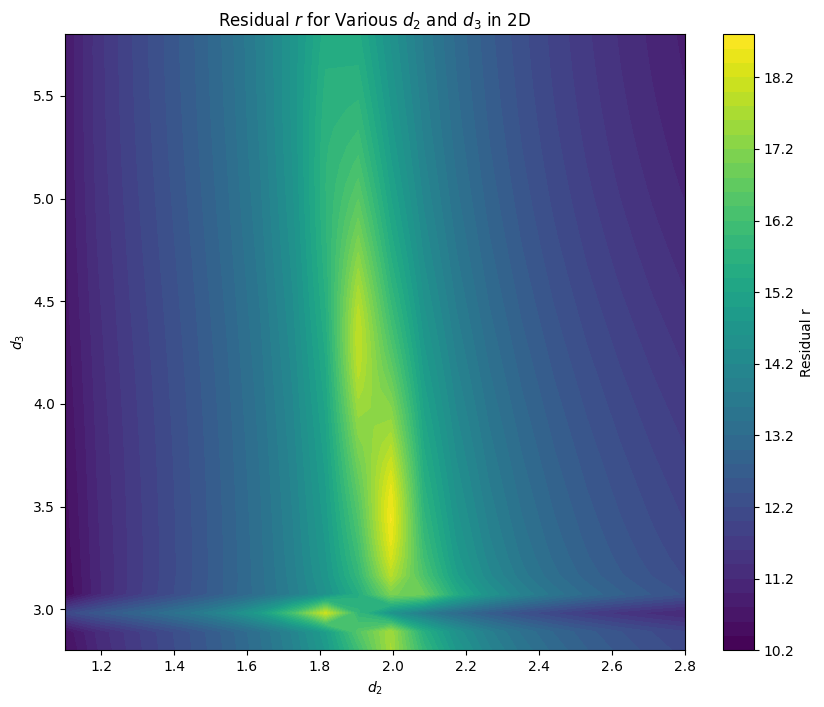

In [33]:
import matplotlib.pyplot as plt
def plot_r(d2_vals, d3_vals, r_matrix):
    plt.figure(figsize=(10, 8))
    # Create meshgrid
    D2, D3 = np.meshgrid(d2_vals, d3_vals, indexing='ij')
    # Plot r as contour
    cp = plt.contourf(D2, D3, r_matrix, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Residual r')
    plt.xlabel('$d_2$')
    plt.ylabel('$d_3$')
    plt.title('Residual $r$ for Various $d_2$ and $d_3$ in 2D')
    plt.show()

# ============================================================
# Example usage:
if __name__ == "__main__":
    # Define spinsYL, assuming [0.0, 2.0, 4.0, 0.0]
    spinsYL = [0.0, 2.0, 4.0, 0.0]

    # Define d2 and d3 ranges
    step = 1.0 / 11.0
    d2_start = 11.0 / 10.0  # 1.1
    d2_end = 28.0 / 10.0    # 2.8
    d3_start = 28.0 / 10.0  # 2.8
    d3_end = 58.0 / 10.0    # 5.8

    # Generate step sizes
    num_steps_d2 = int(round((d2_end - d2_start) / step)) + 1
    num_steps_d3 = int(round((d3_end - d3_start) / step)) + 1

    d2_vals = np.linspace(d2_start, d2_end, num_steps_d2)
    d3_vals = np.linspace(d3_start, d3_end, num_steps_d3)

    # Prepare a grid to store r
    r_matrix = np.zeros((len(d2_vals), len(d3_vals)), dtype=np.float64)

    # Iterate over d2 and d3
    for i, d2 in enumerate(d2_vals):
        for j, d3 in enumerate(d3_vals):
            deltas = np.array([ -2.0/5.0, d2, d3, 38.0/5.0 ])
            try:
                c, r = leastSqRew(deltas, spinsYL, dSigma=-4.0/10.0,N_z=100,std=.2)
                r_matrix[i,j] = r
            except Exception as e:
                # Handle exceptions (e.g., singular matrix)
                print(f"Error at d2={d2:.3f}, d3={d3:.3f}: {e}")
                r_matrix[i,j] = np.nan
            print(f"d2={d2:.3f}, d3={d3:.3f}, r={r:.3f}")

    # Plot the residuals
    plot_r(d2_vals, d3_vals, r_matrix)

d1=-0.990, d2=1.110, r=8.370
d1=-0.990, d2=1.121, r=8.361
d1=-0.990, d2=1.132, r=8.350
d1=-0.990, d2=1.143, r=8.339
d1=-0.990, d2=1.154, r=8.327
d1=-0.990, d2=1.165, r=8.316
d1=-0.990, d2=1.176, r=8.304
d1=-0.990, d2=1.187, r=8.291
d1=-0.990, d2=1.198, r=8.279
d1=-0.990, d2=1.209, r=8.266
d1=-0.990, d2=1.220, r=8.254
d1=-0.990, d2=1.231, r=8.241
d1=-0.990, d2=1.242, r=8.228
d1=-0.990, d2=1.253, r=8.215
d1=-0.990, d2=1.264, r=8.203
d1=-0.990, d2=1.275, r=8.190
d1=-0.990, d2=1.286, r=8.177
d1=-0.990, d2=1.297, r=8.164
d1=-0.990, d2=1.308, r=8.151
d1=-0.990, d2=1.319, r=8.138
d1=-0.990, d2=1.330, r=8.125
d1=-0.990, d2=1.341, r=8.112
d1=-0.990, d2=1.352, r=8.099
d1=-0.990, d2=1.363, r=8.085
d1=-0.990, d2=1.374, r=8.072
d1=-0.990, d2=1.385, r=8.059
d1=-0.990, d2=1.396, r=8.046
d1=-0.990, d2=1.407, r=8.033
d1=-0.990, d2=1.418, r=8.020
d1=-0.990, d2=1.428, r=8.007
d1=-0.990, d2=1.439, r=7.993
d1=-0.990, d2=1.450, r=7.980
d1=-0.990, d2=1.461, r=7.967
d1=-0.990, d2=1.472, r=7.954
d1=-0.990, d2=

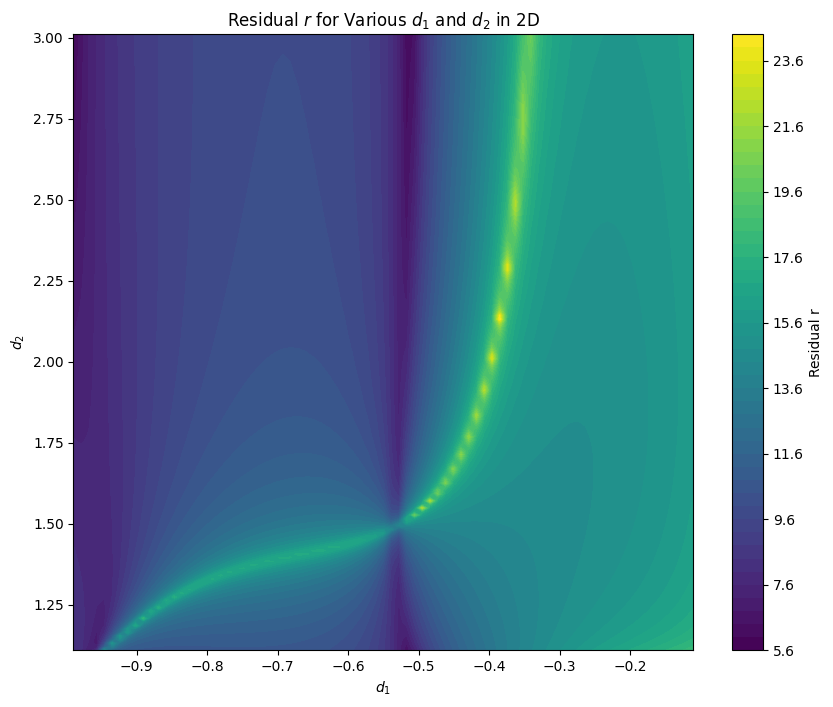

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_r(d1_vals, d2_vals, r_matrix):
    plt.figure(figsize=(10, 8))
    # Create meshgrid
    D1, D2 = np.meshgrid(d1_vals, d2_vals, indexing='ij')
    # Plot r as contour
    cp = plt.contourf(D1, D2, r_matrix, levels=50, cmap='viridis')
    plt.colorbar(cp, label='Residual r')
    plt.xlabel('$d_1$')
    plt.ylabel('$d_2$')
    plt.title('Residual $r$ for Various $d_1$ and $d_2$ in 2D')
    plt.show()

# ============================================================
# Example usage:
if __name__ == "__main__":
    # Define spinsYL, assuming [0.0, 2.0, 4.0, 0.0]
    spinsYL = [0.0, 2.0, 4.0, 0.0]

    # Define d1 and d2 ranges
    step = 0.011
    d1_start = -0.99
    d1_end = -0.11
    d2_start = 1.11
    d2_end = 3.01

    # Fixed values for d3 and d4
    d3 = 3.6
    d4 = 7.6

    # Generate step sizes
    num_steps_d1 = int(round((d1_end - d1_start) / step)) + 1
    num_steps_d2 = int(round((d2_end - d2_start) / step)) + 1

    d1_vals = np.linspace(d1_start, d1_end, num_steps_d1)
    d2_vals = np.linspace(d2_start, d2_end, num_steps_d2)

    # Prepare a grid to store r
    r_matrix = np.zeros((len(d1_vals), len(d2_vals)), dtype=np.float64)

    # Iterate over d1 and d2
    for i, d1 in enumerate(d1_vals):
        for j, d2 in enumerate(d2_vals):
            deltas = np.array([d1, d2, d3, d4])
            try:
                c, r = leastSqRew(deltas, spinsYL, dSigma=-4.0 / 10.0)
                r_matrix[i, j] = r
            except Exception as e:
                # Handle exceptions (e.g., singular matrix)
                print(f"Error at d1={d1:.3f}, d2={d2:.3f}: {e}")
                r_matrix[i, j] = np.nan
            print(f"d1={d1:.3f}, d2={d2:.3f}, r={r:.3f}")

    # Plot the residuals
    plot_r(d1_vals, d2_vals, r_matrix)
